Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loaded Pointcept data from /home/knuvi/Desktop/song/Pointcept/data/scannet/val/scene0011_00: 237360 points
Segment20 label distribution: min=-1, max=19
All 3DGS normals are zero. Estimating normals...
Loaded 3DGS data from /home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output/scene0011_00/point_cloud.ply: 314733 points


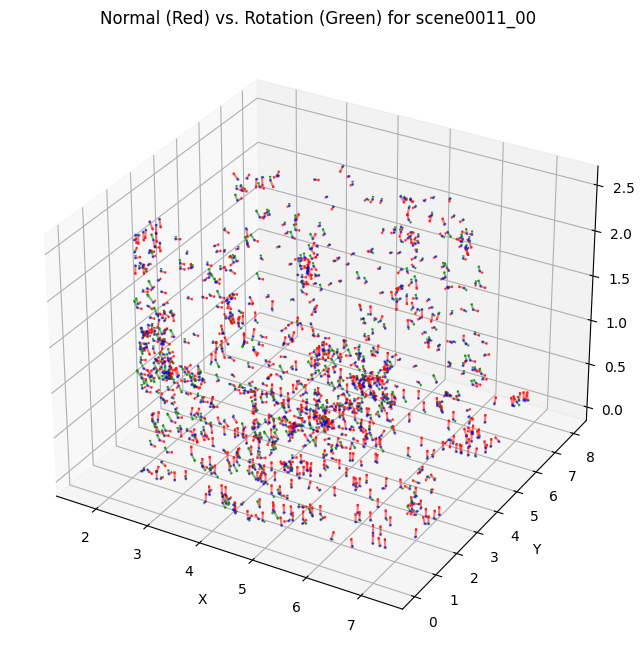

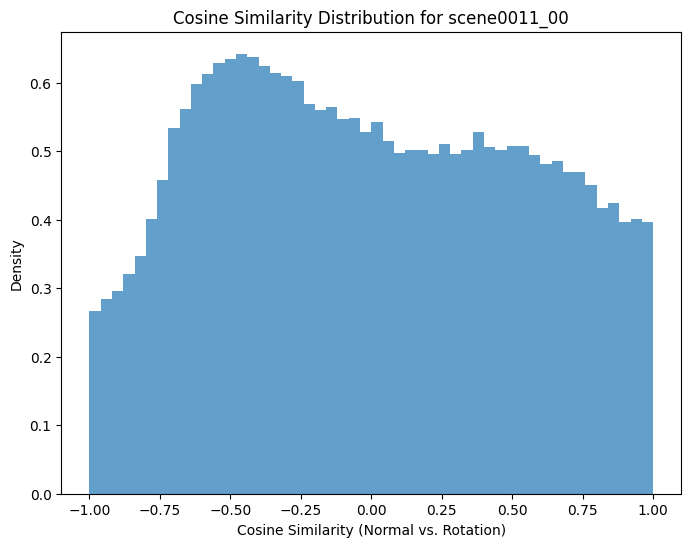

Mean Cosine Similarity: -0.0055
Std Cosine Similarity: 0.5398
Percentage of points with Cosine Similarity > 0.8: 8.14%


In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import load_pointcept_data, load_3dgs_data
from fusion_utils import preprocess_3dgs_attributes, augment_pointcept_with_3dgs_attributes

# Config 로드
config_path = '/home/knuvi/Desktop/song/gaussian-point-sampler/config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

input_root = config['input_root']  # 예: /home/knuvi/Desktop/song/Pointcept/data/scannet
path_3dgs_root = config['path_3dgs_root']  # 예: /home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output
k_neighbors = config['prune_params']['k_neighbors']  # 예: 5

# Scene 설정
scene = 'scene0011_00'
pointcept_dir = os.path.join(input_root, 'val', scene)
path_3dgs = os.path.join(path_3dgs_root, scene, 'point_cloud.ply')

# 데이터 로드
pointcept_data = load_pointcept_data(pointcept_dir)
points_pointcept = pointcept_data['coord']  # [N, 3]
normals_pointcept = pointcept_data['normal']  # [N, 3]

points_3dgs, normals_3dgs, raw_features_3dgs = load_3dgs_data(path_3dgs)  # [M, 3], [M, 3], raw features
features_3dgs = preprocess_3dgs_attributes(raw_features_3dgs)  # [M, K], 마지막 3개는 rotation [dir_x, dir_y, dir_z]

# Rotation 추출 및 역스케일링
rotation_3dgs = features_3dgs[:, -3:]  # [M, 3], [0, 1] 범위
rotation_3dgs = rotation_3dgs * 2 - 1  # [0, 1] -> [-1, 1], 단위 벡터로 복원

# Pointcept 점에 3DGS rotation 매핑
features_pointcept, _ = augment_pointcept_with_3dgs_attributes(
    points_pointcept, points_3dgs, features_3dgs, k_neighbors=k_neighbors, use_features=['rotation']
)
rotation_pointcept = features_pointcept[:, -3:]  # [N, 3], [0, 1] 범위
rotation_pointcept = rotation_pointcept * 2 - 1  # [0, 1] -> [-1, 1]

# 코사인 유사도 계산
alignment_scores = np.sum(normals_pointcept * rotation_pointcept, axis=1) / (
    np.linalg.norm(normals_pointcept, axis=1) * np.linalg.norm(rotation_pointcept, axis=1) + 1e-8
)

# 시각화: 포인트 클라우드와 방향 벡터
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 포인트 클라우드 (샘플링으로 축소)
sample_idx = np.random.choice(points_pointcept.shape[0], 1000, replace=False)
points_sample = points_pointcept[sample_idx]
normals_sample = normals_pointcept[sample_idx]
rotation_sample = rotation_pointcept[sample_idx]

# 포인트 플롯
ax.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2], c='b', s=1, alpha=0.5)

# Normal 벡터 (빨간색)
scale = 0.1  # 벡터 길이 스케일링
for i in range(len(points_sample)):
    ax.quiver(
        points_sample[i, 0], points_sample[i, 1], points_sample[i, 2],
        normals_sample[i, 0] * scale, normals_sample[i, 1] * scale, normals_sample[i, 2] * scale,
        color='r', alpha=0.5
    )

# Rotation 벡터 (녹색)
for i in range(len(points_sample)):
    ax.quiver(
        points_sample[i, 0], points_sample[i, 1], points_sample[i, 2],
        rotation_sample[i, 0] * scale, rotation_sample[i, 1] * scale, rotation_sample[i, 2] * scale,
        color='g', alpha=0.5
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Normal (Red) vs. Rotation (Green) for {scene}')
plt.show()

# 코사인 유사도 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(alignment_scores, bins=50, range=(-1, 1), density=True, alpha=0.7)
plt.xlabel('Cosine Similarity (Normal vs. Rotation)')
plt.ylabel('Density')
plt.title(f'Cosine Similarity Distribution for {scene}')
plt.show()

# 통계 출력
print(f"Mean Cosine Similarity: {np.mean(alignment_scores):.4f}")
print(f"Std Cosine Similarity: {np.std(alignment_scores):.4f}")
print(f"Percentage of points with Cosine Similarity > 0.8: {100 * np.sum(alignment_scores > 0.8) / len(alignment_scores):.2f}%")

Loaded Pointcept data from /home/knuvi/Desktop/song/Pointcept/data/scannet/val/scene0011_00: 237360 points
Segment20 label distribution: min=-1, max=19
All 3DGS normals are zero. Estimating normals...
Loaded 3DGS data from /home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output/scene0011_00/point_cloud.ply: 314733 points


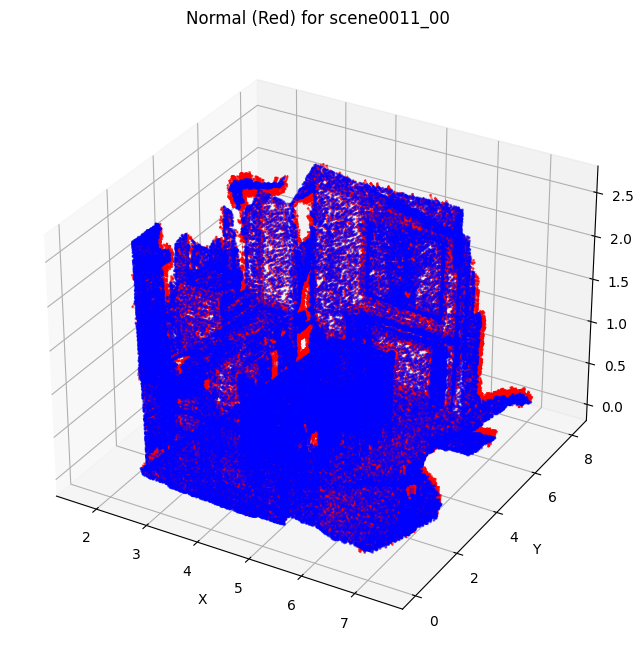

KeyboardInterrupt: 

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import load_pointcept_data, load_3dgs_data
from fusion_utils import preprocess_3dgs_attributes, augment_pointcept_with_3dgs_attributes
from sklearn.neighbors import NearestNeighbors

# Config 로드
config_path = '/home/knuvi/Desktop/song/gaussian-point-sampler/config.json'

with open(config_path, 'r') as f:
    config = json.load(f)

input_root = config['input_root']  # 예: /home/knuvi/Desktop/song/Pointcept/data/scannet
path_3dgs_root = config['path_3dgs_root']  # 예: /home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output
k_neighbors = config['prune_params']['k_neighbors']  # 예: 5

# Scene 설정
scene = 'scene0011_00'
pointcept_dir = os.path.join(input_root, 'val', scene)
path_3dgs = os.path.join(path_3dgs_root, scene, 'point_cloud.ply')

# 데이터 로드
pointcept_data = load_pointcept_data(pointcept_dir)
points_pointcept = pointcept_data['coord']  # [N, 3]
normals_pointcept = pointcept_data['normal']  # [N, 3]

points_3dgs, normals_3dgs, raw_features_3dgs = load_3dgs_data(path_3dgs)  # [M, 3], [M, 3], raw features
features_3dgs = preprocess_3dgs_attributes(raw_features_3dgs)  # [M, K], 마지막 3개는 rotation [dir_x, dir_y, dir_z]

# Rotation 추출 및 역스케일링
rotation_3dgs = features_3dgs[:, -3:]  # [M, 3], [0, 1] 범위
rotation_3dgs = rotation_3dgs * 2 - 1  # [0, 1] -> [-1, 1], 단위 벡터로 복원

# Pointcept 점에 3DGS rotation 매핑
features_pointcept, _ = augment_pointcept_with_3dgs_attributes(
    points_pointcept, points_3dgs, features_3dgs, k_neighbors=k_neighbors, use_features=['rotation']
)
rotation_pointcept = features_pointcept[:, -3:]  # [N, 3], [0, 1] 범위
rotation_pointcept = rotation_pointcept * 2 - 1  # [0, 1] -> [-1, 1]

# 샘플링 (필요 시)
sample_idx = np.random.choice(points_pointcept.shape[0], 100000, replace=False)
points_sample = points_pointcept[sample_idx]
normals_sample = normals_pointcept[sample_idx]
rotation_sample = rotation_pointcept[sample_idx]

# 1. Normal 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 포인트 플롯
ax.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2], c='b', s=1, alpha=0.5)

# Normal 벡터 (빨간색)
scale = 0.1  # 벡터 길이 스케일링
for i in range(len(points_sample)):
    ax.quiver(
        points_sample[i, 0], points_sample[i, 1], points_sample[i, 2],
        normals_sample[i, 0] * scale, normals_sample[i, 1] * scale, normals_sample[i, 2] * scale,
        color='r', alpha=0.5
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Normal (Red) for {scene}')
plt.show()

# 2. Rotation 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 포인트 플롯
ax.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2], c='b', s=1, alpha=0.5)

# Rotation 벡터 (녹색)
for i in range(len(points_sample)):
    ax.quiver(
        points_sample[i, 0], points_sample[i, 1], points_sample[i, 2],
        rotation_sample[i, 0] * scale, rotation_sample[i, 1] * scale, rotation_sample[i, 2] * scale,
        color='g', alpha=0.5
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Rotation (Green) for {scene}')
plt.show()

# 3. Rotation 간 일관성 (consistency_score) 계산 및 시각화
# KNN으로 주변 점 찾기
knn = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(points_pointcept)
distances, indices = knn.kneighbors(points_pointcept)

# Consistency score 계산
consistency_scores = np.zeros(points_pointcept.shape[0])
for i in range(points_pointcept.shape[0]):
    neighbor_idx = indices[i, 1:]  # 자기 자신 제외
    rot_i = rotation_pointcept[i]
    rot_neighbors = rotation_pointcept[neighbor_idx]
    cos_sim = np.sum(rot_i * rot_neighbors, axis=1) / (
        np.linalg.norm(rot_i) * np.linalg.norm(rot_neighbors, axis=1) + 1e-8
    )
    consistency_scores[i] = np.mean(cos_sim)

# Consistency score에 따라 색상 지정 (낮은 일관성: 빨강, 높은 일관성: 파랑)
colors = plt.cm.coolwarm((consistency_scores + 1) / 2)  # [-1, 1] -> [0, 1]

# Consistency 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 포인트 플롯 (일관성에 따라 색상 지정)
scatter = ax.scatter(
    points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
    c=colors[sample_idx], s=1, alpha=0.5
)

# 컬러바 추가
plt.colorbar(scatter, ax=ax, label='Consistency Score (-1 to 1)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Rotation Consistency for {scene}')
plt.show()

# Consistency score 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(consistency_scores, bins=50, range=(-1, 1), density=True, alpha=0.7)
plt.xlabel('Consistency Score (Rotation)')
plt.ylabel('Density')
plt.title(f'Rotation Consistency Distribution for {scene}')
plt.show()

# 통계 출력
print(f"Mean Consistency Score: {np.mean(consistency_scores):.4f}")
print(f"Std Consistency Score: {np.std(consistency_scores):.4f}")
print(f"Percentage of points with Consistency Score > 0.8: {100 * np.sum(consistency_scores > 0.8) / len(consistency_scores):.2f}%")

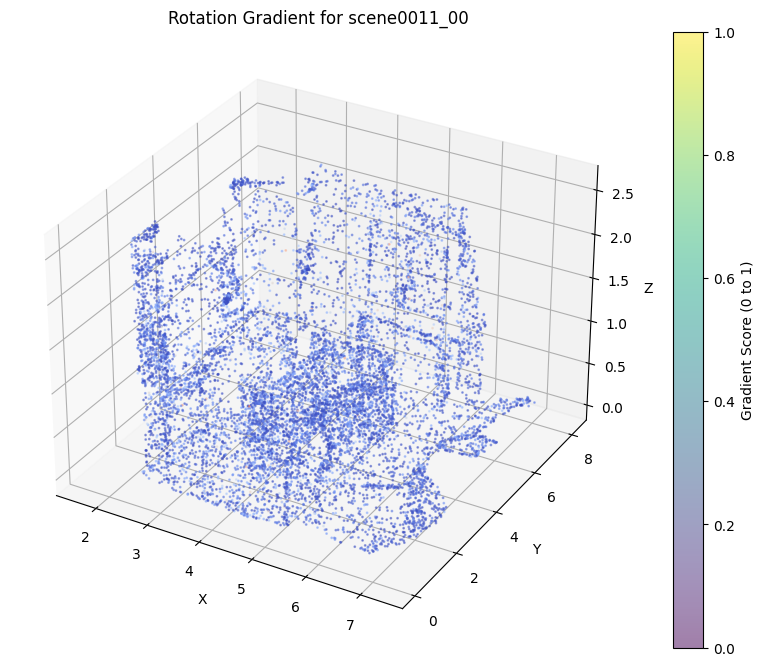

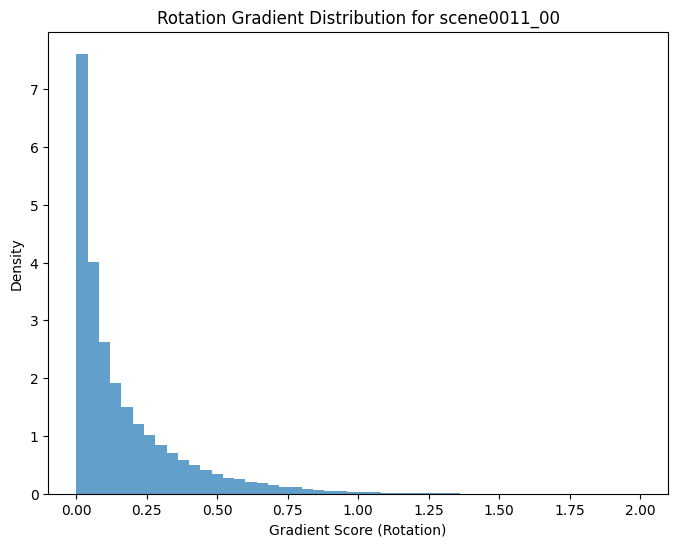

Mean Gradient Score: 0.1685
Std Gradient Score: 0.1997
Percentage of points with Gradient Score > 0.5: 7.55%


In [6]:
# Gradient Score 계산 및 시각화
gradient_scores = np.zeros(points_pointcept.shape[0])
for i in range(points_pointcept.shape[0]):
    neighbor_idx = indices[i, 1:]  # 자기 자신 제외
    rot_i = rotation_pointcept[i]
    rot_neighbors = rotation_pointcept[neighbor_idx]
    cos_sim = np.sum(rot_i * rot_neighbors, axis=1) / (
        np.linalg.norm(rot_i) * np.linalg.norm(rot_neighbors, axis=1) + 1e-8
    )
    gradient_scores[i] = np.mean(1 - cos_sim)

# Gradient score에 따라 색상 지정 (높은 변화도: 빨강, 낮은 변화도: 파랑)
colors = plt.cm.coolwarm((gradient_scores - gradient_scores.min()) / (gradient_scores.max() - gradient_scores.min() + 1e-8))

# Gradient 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 포인트 플롯 (변화도에 따라 색상 지정)
scatter = ax.scatter(
    points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
    c=colors[sample_idx], s=1, alpha=0.5
)

# 컬러바 추가
plt.colorbar(scatter, ax=ax, label='Gradient Score (0 to 1)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Rotation Gradient for {scene}')
plt.show()

# Gradient score 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(gradient_scores, bins=50, range=(0, 2), density=True, alpha=0.7)
plt.xlabel('Gradient Score (Rotation)')
plt.ylabel('Density')
plt.title(f'Rotation Gradient Distribution for {scene}')
plt.show()

# 통계 출력
print(f"Mean Gradient Score: {np.mean(gradient_scores):.4f}")
print(f"Std Gradient Score: {np.std(gradient_scores):.4f}")
print(f"Percentage of points with Gradient Score > 0.5: {100 * np.sum(gradient_scores > 0.5) / len(gradient_scores):.2f}%")

In [7]:
# Gradient Score 재계산 (k=20)
k_neighbors = 20
knn = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(points_pointcept)
distances, indices = knn.kneighbors(points_pointcept)

gradient_scores = np.zeros(points_pointcept.shape[0])
for i in range(points_pointcept.shape[0]):
    neighbor_idx = indices[i, 1:]  # 자기 자신 제외
    rot_i = rotation_pointcept[i]
    rot_neighbors = rotation_pointcept[neighbor_idx]
    cos_sim = np.sum(rot_i * rot_neighbors, axis=1) / (
        np.linalg.norm(rot_i) * np.linalg.norm(rot_neighbors, axis=1) + 1e-8
    )
    gradient_scores[i] = np.mean(1 - cos_sim)

# 통계 출력
print(f"Mean Gradient Score (k=20): {np.mean(gradient_scores):.4f}")
print(f"Std Gradient Score (k=20): {np.std(gradient_scores):.4f}")
print(f"Percentage of points with Gradient Score > 0.3 (k=20): {100 * np.sum(gradient_scores > 0.3) / len(gradient_scores):.2f}%")
print(f"Percentage of points with Gradient Score > 0.5 (k=20): {100 * np.sum(gradient_scores > 0.5) / len(gradient_scores):.2f}%")

Mean Gradient Score (k=20): 0.2748
Std Gradient Score (k=20): 0.2315
Percentage of points with Gradient Score > 0.3 (k=20): 36.02%
Percentage of points with Gradient Score > 0.5 (k=20): 15.70%


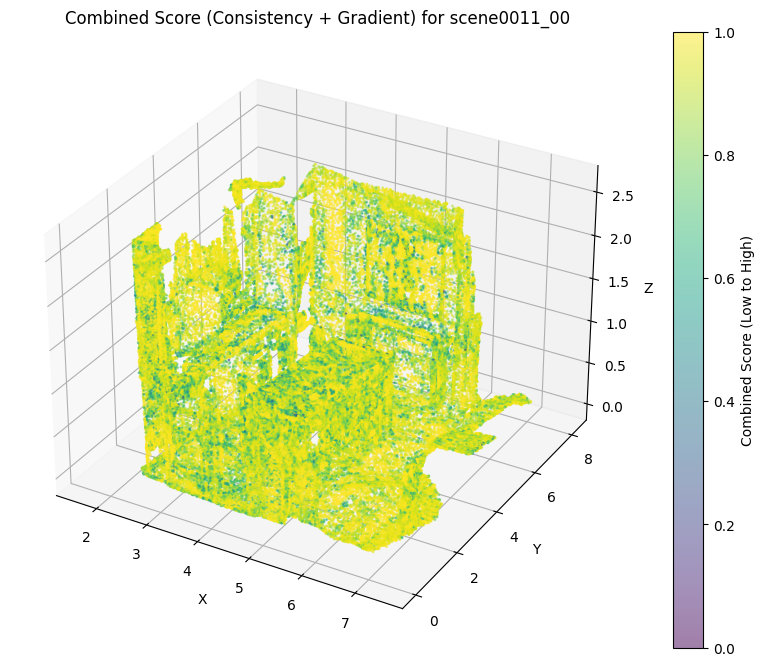

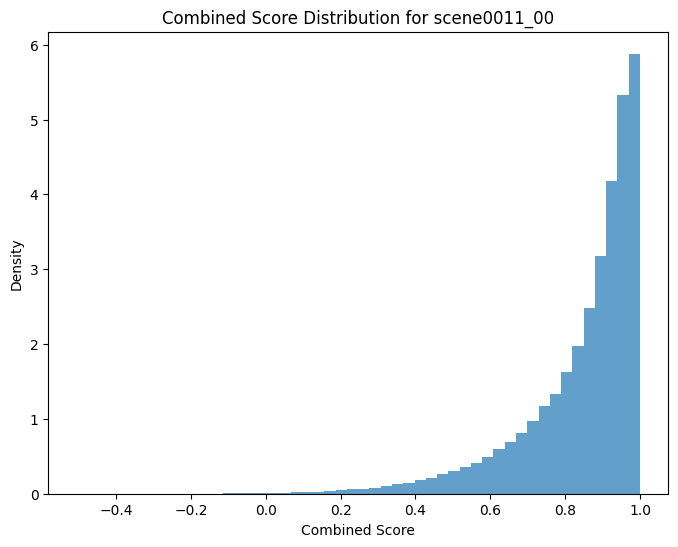

Mean Combined Score: 0.8439
Std Combined Score: 0.1597
Percentage of points with Combined Score < 0.5: 4.68%


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 이전 코드에서 계산된 데이터 가정
# points_pointcept: [N, 3], rotation_pointcept: [N, 3]
# consistency_scores: [N], gradient_scores: [N] (k=20)

# 1. Combined Score 계산
w_c, w_g = 0.6, 0.4
combined_scores = w_c * consistency_scores + w_g * (1 - gradient_scores / 2)  # gradient_scores를 [0, 2] -> [0, 1]로 스케일링

# 2. 샘플링 (필요 시)
sample_idx = np.random.choice(points_pointcept.shape[0], 100000, replace=False)
points_sample = points_pointcept[sample_idx]
combined_sample = combined_scores[sample_idx]

# 3. Combined Score에 따라 색상 지정 (낮은 점수: 빨강, 높은 점수: 파랑)
colors = plt.cm.viridis((combined_scores - combined_scores.min()) / (combined_scores.max() - combined_scores.min() + 1e-8))

# 4. 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 포인트 플롯 (combined score에 따라 색상 지정)
scatter = ax.scatter(
    points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
    c=colors[sample_idx], s=1, alpha=0.5
)

# 컬러바 추가
plt.colorbar(scatter, ax=ax, label='Combined Score (Low to High)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Combined Score (Consistency + Gradient) for {scene}')
plt.show()

# 5. Combined Score 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(combined_scores, bins=50, density=True, alpha=0.7)
plt.xlabel('Combined Score')
plt.ylabel('Density')
plt.title(f'Combined Score Distribution for {scene}')
plt.show()

# 6. 통계 출력
print(f"Mean Combined Score: {np.mean(combined_scores):.4f}")
print(f"Std Combined Score: {np.std(combined_scores):.4f}")
print(f"Percentage of points with Combined Score < 0.5: {100 * np.sum(combined_scores < 0.5) / len(combined_scores):.2f}%")

Label 0:
  Mean Combined Score: 0.8586
  Std Combined Score: 0.1507
  Percentage with Combined Score < 0.5: 3.92%
Label 1:
  Mean Combined Score: 0.8446
  Std Combined Score: 0.1446
  Percentage with Combined Score < 0.5: 3.59%
Label 2:
  Mean Combined Score: 0.8404
  Std Combined Score: 0.1605
  Percentage with Combined Score < 0.5: 4.69%
Label 4:
  Mean Combined Score: 0.8386
  Std Combined Score: 0.1631
  Percentage with Combined Score < 0.5: 5.04%
Label 6:
  Mean Combined Score: 0.8269
  Std Combined Score: 0.1777
  Percentage with Combined Score < 0.5: 6.57%
Label 7:
  Mean Combined Score: 0.8452
  Std Combined Score: 0.1605
  Percentage with Combined Score < 0.5: 4.96%
Label 8:
  Mean Combined Score: 0.8270
  Std Combined Score: 0.1756
  Percentage with Combined Score < 0.5: 6.31%
Label 11:
  Mean Combined Score: 0.8279
  Std Combined Score: 0.1908
  Percentage with Combined Score < 0.5: 7.52%
Label 14:
  Mean Combined Score: 0.8282
  Std Combined Score: 0.1867
  Percentage with 

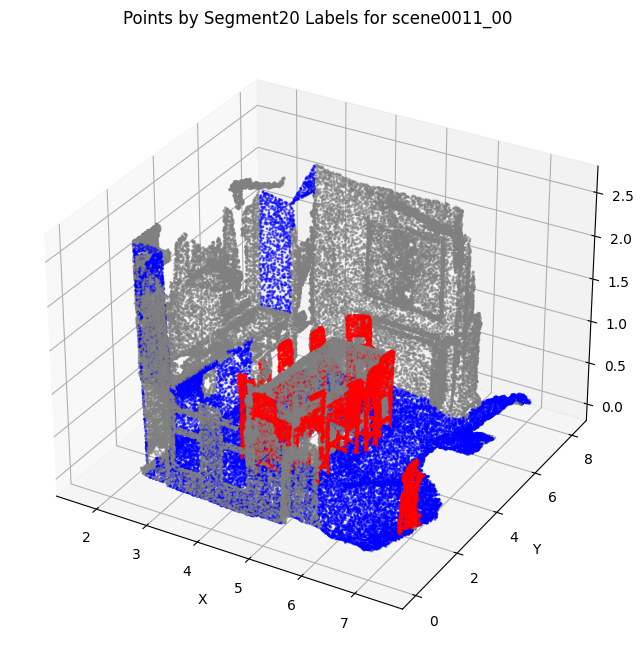

In [18]:
# Pointcept 데이터에서 segment20 레이블 로드
labels = pointcept_data['segment20']  # [N], segment20 레이블

# 레이블별 Combined Score 분석
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:  # Unlabeled
        continue
    mask = labels == label
    label_scores = combined_scores[mask]
    print(f"Label {label}:")
    print(f"  Mean Combined Score: {np.mean(label_scores):.4f}")
    print(f"  Std Combined Score: {np.std(label_scores):.4f}")
    print(f"  Percentage with Combined Score < 0.5: {100 * np.sum(label_scores < 0.5) / len(label_scores):.2f}%")

# 레이블별 시각화 (선택)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 레이블별 색상 지정 (간단히 3개 클래스 예시)
colors = np.zeros((len(points_sample), 3))
for i, idx in enumerate(sample_idx):
    label = labels[idx]
    if label in [1, 2]:  # 벽, 바닥 (평면)
        colors[i] = [0, 0, 1]  # 파랑
    elif label in [3, 4]:  # 가구 (경계 포함)
        colors[i] = [1, 0, 0]  # 빨강
    else:
        colors[i] = [0.5, 0.5, 0.5]  # 회색 (기타)

scatter = ax.scatter(
    points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
    c=colors, s=1, alpha=0.5
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Points by Segment20 Labels for {scene}')
plt.show()

In [22]:
from sklearn.cluster import DBSCAN

# DBSCAN 설정 조정
eps = 0.05
min_samples = 20
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(points_pointcept)
cluster_labels = dbscan.labels_  # [N], -1은 노이즈

# 클러스터별 Combined Score 재분석
unique_clusters = np.unique(cluster_labels)
for cluster in unique_clusters:
    if cluster == -1:  # 노이즈
        continue
    mask = cluster_labels == cluster
    cluster_scores = combined_scores[mask]
    print(f"Cluster {cluster}:")
    print(f"  Mean Combined Score: {np.mean(cluster_scores):.4f}")
    print(f"  Std Combined Score: {np.std(cluster_scores):.4f}")
    print(f"  Percentage with Combined Score < 0.5: {100 * np.sum(cluster_scores < 0.5) / len(cluster_scores):.2f}%")

# 노이즈 점 분석
noise_mask = cluster_labels == -1
noise_scores = combined_scores[noise_mask]
print(f"Noise Points:")
print(f"  Mean Combined Score: {np.mean(noise_scores):.4f}")
print(f"  Percentage with Combined Score < 0.5: {100 * np.sum(noise_scores < 0.5) / len(noise_scores):.2f}%")

Cluster 0:
  Mean Combined Score: 0.8483
  Std Combined Score: 0.1609
  Percentage with Combined Score < 0.5: 4.70%
Cluster 1:
  Mean Combined Score: 0.8078
  Std Combined Score: 0.1898
  Percentage with Combined Score < 0.5: 8.11%
Cluster 2:
  Mean Combined Score: 0.6791
  Std Combined Score: 0.1558
  Percentage with Combined Score < 0.5: 5.00%
Cluster 3:
  Mean Combined Score: 0.8666
  Std Combined Score: 0.1182
  Percentage with Combined Score < 0.5: 1.95%
Cluster 4:
  Mean Combined Score: 0.9126
  Std Combined Score: 0.0598
  Percentage with Combined Score < 0.5: 0.00%
Cluster 5:
  Mean Combined Score: 0.9272
  Std Combined Score: 0.0799
  Percentage with Combined Score < 0.5: 0.56%
Cluster 6:
  Mean Combined Score: 0.9181
  Std Combined Score: 0.1085
  Percentage with Combined Score < 0.5: 0.00%
Cluster 7:
  Mean Combined Score: 0.7479
  Std Combined Score: 0.2150
  Percentage with Combined Score < 0.5: 16.59%
Cluster 8:
  Mean Combined Score: 0.9023
  Std Combined Score: 0.0858
 

In [20]:
# Pruning 시뮬레이션 (하위 20% 제거)
prune_ratio = 0.2
threshold = np.percentile(combined_scores, prune_ratio * 100)
mask = combined_scores >= threshold

# Pruning 후 점
remaining_consistency = consistency_scores[mask]
remaining_gradient = gradient_scores[mask]

# 통계 비교
print("Before Pruning:")
print(f"  Mean Consistency Score: {np.mean(consistency_scores):.4f}")
print(f"  Mean Gradient Score: {np.mean(gradient_scores):.4f}")
print("After Pruning:")
print(f"  Mean Consistency Score: {np.mean(remaining_consistency):.4f}")
print(f"  Mean Gradient Score: {np.mean(remaining_gradient):.4f}")

Before Pruning:
  Mean Consistency Score: 0.8315
  Mean Gradient Score: 0.2748
After Pruning:
  Mean Consistency Score: 0.9130
  Mean Gradient Score: 0.1908


In [21]:
# 레이블별 Gradient Score 분석
for label in unique_labels:
    if label == -1:  # Unlabeled
        continue
    mask = labels == label
    label_gradients = gradient_scores[mask]
    print(f"Label {label}:")
    print(f"  Mean Gradient Score: {np.mean(label_gradients):.4f}")
    print(f"  Std Gradient Score: {np.std(label_gradients):.4f}")
    print(f"  Percentage with Gradient Score > 0.3: {100 * np.sum(label_gradients > 0.3) / len(label_gradients):.2f}%")

Label 0:
  Mean Gradient Score: 0.2496
  Std Gradient Score: 0.2222
  Percentage with Gradient Score > 0.3: 30.50%
Label 1:
  Mean Gradient Score: 0.2773
  Std Gradient Score: 0.2106
  Percentage with Gradient Score > 0.3: 36.98%
Label 2:
  Mean Gradient Score: 0.2780
  Std Gradient Score: 0.2312
  Percentage with Gradient Score > 0.3: 35.44%
Label 4:
  Mean Gradient Score: 0.2860
  Std Gradient Score: 0.2364
  Percentage with Gradient Score > 0.3: 38.63%
Label 6:
  Mean Gradient Score: 0.3010
  Std Gradient Score: 0.2523
  Percentage with Gradient Score > 0.3: 41.31%
Label 7:
  Mean Gradient Score: 0.2753
  Std Gradient Score: 0.2401
  Percentage with Gradient Score > 0.3: 36.57%
Label 8:
  Mean Gradient Score: 0.2965
  Std Gradient Score: 0.2484
  Percentage with Gradient Score > 0.3: 39.28%
Label 11:
  Mean Gradient Score: 0.2859
  Std Gradient Score: 0.2663
  Percentage with Gradient Score > 0.3: 36.17%
Label 14:
  Mean Gradient Score: 0.2907
  Std Gradient Score: 0.2686
  Percenta